In [1]:
import matplotlib as plt
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

import warnings
warnings.simplefilter('ignore') #filter some warning messages

In [2]:
ds = xr.open_dataset('cciea_HCI.nc')
ds.close()
#ds = ds.sel(time=slice('1980-01-01','2020-12-31'))
# make a new one
ds1 = xr.Dataset(data_vars=dict(hci1=(['time'],ds.hci_regn1.values),
                               hci2=(['time'],ds.hci_regn2.values),
                               hci3=(['time'],ds.hci_regn3.values),
                               hci4=(['time'],ds.hci_regn4.values)
                               ),
                coords=dict(time=ds.time.values))
ds1 = ds1.sel(time=slice('1980-01-01','2020-12-31'))
dsa = ds1.resample(time='12MS').mean()
dsa

<xarray.Dataset>
Dimensions:  (time: 41)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1981-01-01 ... 2020-01-01
Data variables:
    hci1     (time) float32 0.23215644 0.104593776 ... 0.22361428 0.34453306
    hci2     (time) float32 0.16453633 0.12619047 ... 0.32606515 0.5117794
    hci3     (time) float32 0.12927583 0.22725616 ... 0.27392647 0.42403567
    hci4     (time) float32 0.44096112 0.39237216 ... 0.43710065 0.40794727

In [3]:
def calculate_trend(x,y,iy,fy):
    # first degree polynomial
    polf = PolynomialFeatures(1)
    # select years
    a = (x>=iy) & (x<=fy)
    x = x[a]
    y = y[a]
    
    # get rid of nan years
    a = ~np.isnan(y)
    y2=y[a]
    x2=x[a]
    y2 = y2.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)

    # calculate years
    xp = polf.fit_transform(x2)
    mods2 = sm.OLS(y2,xp).fit()
    trend = mods2.params[1]*10
    p_tr = mods2.pvalues[1]

    return trend, p_tr

0.0023162693615988786 0.890511823151096
0.02613510348499832 0.29991632902689846
0.03189048289162329 0.24617424337832491


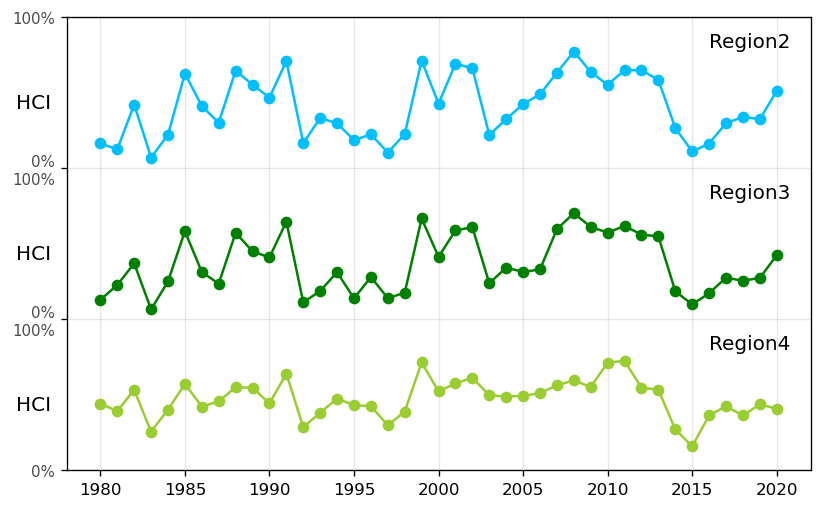

In [5]:
years=np.array(range(1980,2021))
var = ['hci4','hci3','hci2']
lab = ['Region4','Region3','Region2']
cls = ['yellowgreen','green','deepskyblue',]
plt.figure(figsize=(8,5), dpi=120)
for i,v in enumerate(var):
    plt.plot(years,dsa[v]+i,'o-', c=cls[i])
    t,p = calculate_trend(years,dsa[v].values,years[0],years[-1])
    print(t,p)
    plt.text(2016,i+0.8,lab[i],fontsize=12)
    plt.text(1975,i+0.4,'HCI',fontsize=12)
plt.grid(True,alpha=0.3,zorder=0)
plt.yticks([*range(0,4)],['0%','0%\n100%','0%\n100%','100%'],fontsize=9,alpha=0.7)
plt.show()

In [6]:
dsa

<xarray.Dataset>
Dimensions:  (time: 41)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1981-01-01 ... 2020-01-01
Data variables:
    hci1     (time) float32 0.23215644 0.104593776 ... 0.22361428 0.34453306
    hci2     (time) float32 0.16453633 0.12619047 ... 0.32606515 0.5117794
    hci3     (time) float32 0.12927583 0.22725616 ... 0.27392647 0.42403567
    hci4     (time) float32 0.44096112 0.39237216 ... 0.43710065 0.40794727

In [7]:
df = pd.DataFrame(data=dsa.hci2.values,columns=['Region2'],index=years.astype(int))
df['Region3'] = dsa.hci3.values
df['Region4'] = dsa.hci4.values
df.to_csv('Upwelling_HCI_OceanIndicators.csv')